## First version of treesignal as a python module
- (On top of lower level C API)
- Right now this module works only with simulated sptree (using the chain of SPR moves)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import sys, subprocess, time, dendropy, os, copy
import numpy as np
from sklearn import manifold, metrics, cluster, neighbors, decomposition, preprocessing
import treesignal

In [32]:
## quick-and-dirty function: user must make sure that gene_chain has enough species
def generate_gene_families(n_species = 32, n_samples=5, n_families=5, n_missing=1, n_spr=1):
    #split chain: sptrees --- gt1 --- sptrees --- gt2 --- ... --- sptrees --- gt_n --- sptrees # 
    # sptrees blocks are twice as long as genetree blocks: 2 X n_s X (n_f +1)
    sp_factor = 2
    n_trees = n_samples * n_families + sp_factor * n_samples * (n_families+1) 
    # generate a SPR chain with "complete" trees
    gf = treesignal.TreeSignal(n_species = n_species, chain_size = n_trees, n_spr = n_spr)
    
    # creation of new sptree set, excluding gene trees
    full_sptrees = gf.sp_trees[:sp_factor*n_samples] 
    for i in range(n_families):
        start = (sp_factor+1)*n_samples*(i+1)
        for j in range(start,start+sp_factor*n_samples):
            full_sptrees.append(gf.sp_trees[j])
        
    # creation of gene trees, each family will have distinct missing data
    all_tx_miss = [] # list with all pruned species
    gt_missing = []  # genes with a few missing taxa
    gt_all_pruned = [] # genes pruned s.t. all have same taxa (i.e. smaller than gt_missing)
    for i in range(n_families):
        tx_miss = np.random.permutation(gf.sp_trees.taxon_namespace)[:n_missing]
        tx_miss = [x.label for x in tx_miss]
        all_tx_miss.append(tx_miss) # is a list of lists
        start = sp_factor*n_samples*(i+1)
        for t in gf.sp_trees[start:start+n_samples]:
            t2 = copy.deepcopy(t)
            t2.prune_taxa_with_labels(tx_miss)
            gt_missing.append(t2)
            
            gt_all_pruned.append(copy.deepcopy(t))
    # gt_all_pruned now will have only taxa in common
    all_tx_miss = list(set([x0 for x in all_tx_miss for x0 in x]))
    for t in gt_all_pruned:
        t.prune_taxa_with_labels(all_tx_miss)
        
    gf.update_spstring_from_trees(full_sptrees)
    cols = np.repeat(range(n_families),n_samples)
    return gt_missing, gf, treesignal.TreeSignal(sp_trees = gt_all_pruned), cols  

gt, gf1, gf2, clabels = generate_gene_families(n_species = 32, n_samples=5, n_families = 5, n_missing=8, n_spr=2)
print (len(gf1.sp_trees), len(gf2.sp_trees), len(gt))
print (len(gf1.sp_trees.taxon_namespace), len(gf2.sp_trees.taxon_namespace))

60 25 25
32 6


In [33]:
feat_miss = gf2() 
feat_full = []
for t in gt:
    feat_full.append (gf1(t))
feat_full = np.array(feat_full)
print (feat_miss.shape, feat_full.shape)

(25, 175) (25, 420)


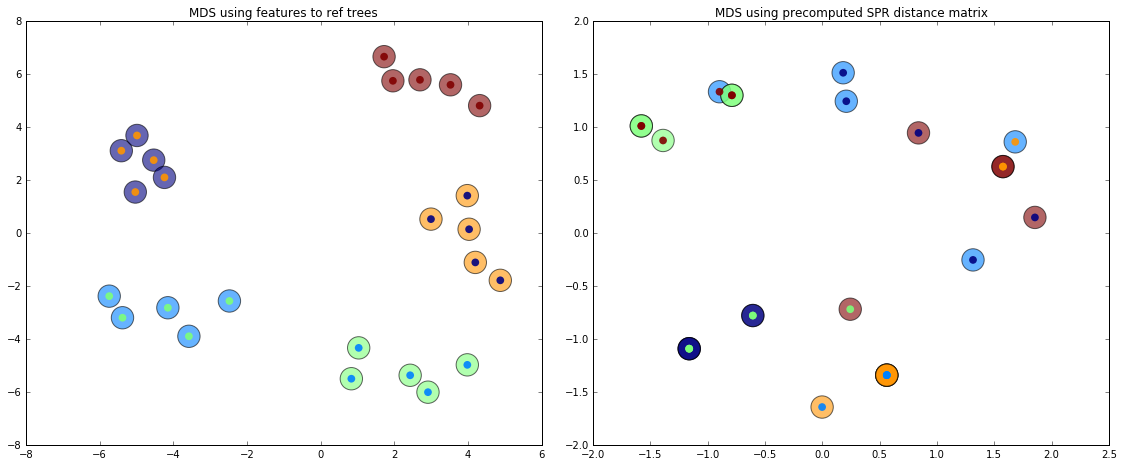

In [38]:
signal_full = feat_full/feat_full.mean(0); 
signal_miss = feat_miss/feat_miss.mean(0);
dist = signal_miss[:,3::7] + signal_miss[:,4::7] # 3rd element is SPR (4 = spr residue, 5 = RF, 6 = Hdist)
dist = (dist + dist.T)/2  # matrix must be symmetric

fig, axes = plt.subplots(1,2) ; fig.set_size_inches(16, 6)
fig.subplots_adjust(top=.99, bottom=.01, left=.03, right=.97, wspace=.1, hspace=.1)

transf=manifold.MDS(n_components=2).fit_transform(signal_full)
kmod1 = cluster.AgglomerativeClustering(n_clusters=5, affinity='cosine', linkage='average').fit(signal_full).labels_
axes[0].scatter(transf[:,1], transf[:,0], c=clabels,edgecolor="black", cmap="jet", alpha=.6, s=500)
axes[0].scatter(transf[:,1], transf[:,0], c=kmod1, edgecolor="none", alpha=.9, s=60)
axes[0].set_title("MDS using features to ref trees")

transf=manifold.MDS(n_components=2, dissimilarity="precomputed").fit_transform(dist)
kmod1 = cluster.AgglomerativeClustering(n_clusters=5, affinity='precomputed', linkage='average').fit(dist).labels_
axes[1].scatter(transf[:,1], transf[:,0], c=clabels, edgecolor="black", cmap="jet", alpha=.6, s=500)
axes[1].scatter(transf[:,1], transf[:,0], c=kmod1, edgecolor="none", alpha=.9, s=60)
axes[1].set_title("MDS using precomputed SPR distance matrix")